# Training Rule-Fit with IRIS dataset 

## 1. Training a Decision Tree

In [100]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
iris = load_iris()
X = iris['data']
Y = iris['target']
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=4)
decision_tree = decision_tree.fit(X, Y)

## 2. Extracting Rules

In [101]:
from sklearn.tree import _tree
import numpy as np

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [(name, "<=", threshold)]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [(name, ">", threshold)]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = {"conditions": [], "response":None, "samples":None, "class":None, "prob":None}
        for p in path[:-1]:
            rule['conditions'].append(p)
        if class_names is None:
            rule['response']= str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule['class'] = class_names[l]
            rule['prob'] = np.round(100.0*classes[l]/np.sum(classes),2)
        rule['samples'] = path[-1][1]
        rules += [rule]
        
    return rules

In [102]:
rules = get_rules(decision_tree, iris['feature_names'], iris['target_names'])
rules[0] 

{'conditions': [('petal width (cm)', '<=', 0.800000011920929)],
 'response': None,
 'samples': 50,
 'class': 'setosa',
 'prob': 100.0}

## 3. Convert original feature to rule features

In [103]:
def compute_rules(rules, single_x, feature_names):
    name_to_index = {feature_names[i] : i for i in range(len(feature_names))}
    r = np.zeros(shape=(len(rules),))
    for i, rule in enumerate(rules):
        agree = True 
        for rule_feature, direction, value in rule['conditions']:
            if direction == "<=":
                if not single_x[name_to_index[rule_feature]] <= value:
                    agree=False 
                    break 
            elif direction == ">":
                if not single_x[name_to_index[rule_feature]] > value:
                    agree=False 
                    break 
            else:
                raise ValueError("Not supported direction")
        if agree:
            r[i] = 1.0
    return r


Rule_X = []

for single_x in X:
    rule_x = compute_rules(rules, single_x, iris['feature_names'])
    Rule_X.append(rule_x)
Rule_X = np.stack(Rule_X)
Rule_X.shape 

(150, 8)

## 4. Training a Linear Classifier with regularization

In [104]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader

class RuleData(Dataset):
    def __init__(self, origin_X, rule_X, targets):
        self.origin_X  = torch.Tensor(origin_X).float()
        self.rule_X = torch.Tensor(rule_X).float()
        self.targets = torch.tensor(targets)

        self.orgin_std = torch.std(self.origin_X, axis=0)
        self.orgin_mean = torch.mean(self.origin_X, axis=0)
    
    def __getitem__(self, idx):
        return (self.rule_X[idx], 
                (self.origin_X[idx] - self.orgin_mean)/self.orgin_std * 0.4, 
                self.targets[idx])
    
    def __len__(self):
        return len(self.origin_X)

class Model(nn.Module):
    def __init__(self, rule_features, origin_features, out_features):
        super().__init__()
        self.rule_linear    = nn.Linear(rule_features,   out_features)
        self.feature_linear = nn.Linear(origin_features, out_features)

    def forward(self, rule, origin):
        x1 = self.rule_linear(rule)
        x2 = self.feature_linear(origin)
        return x1 + x2
    


In [105]:
DEVICE = "cuda:0"
# ==== Dataset ==== 
dataset = RuleData(X, Rule_X, Y)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# ==== Model and Optimizer ====
model = Model(rule_features=Rule_X.shape[1], origin_features=X.shape[1], out_features=3).to(DEVICE)
learning_rate = 1e-2
alpha, beta = 0.01, 0.01
rule_optimizer = torch.optim.SGD(model.rule_linear.parameters(), lr=learning_rate, weight_decay=alpha)
feature_optimizer = torch.optim.SGD(model.feature_linear.parameters(), lr=learning_rate, weight_decay=beta)

epochs = 100
for epoch in range(epochs):
    running_loss = 0 
    for rule, feature, y in train_loader:
        y_hat = model(rule.to(DEVICE), feature.to(DEVICE))

        loss = torch.nn.CrossEntropyLoss()(y_hat, y.to(DEVICE))

        rule_optimizer.zero_grad()
        feature_optimizer.zero_grad()

        loss.backward()

        rule_optimizer.step()
        feature_optimizer.step()

        running_loss += loss.item()
    if epoch % (epochs//5) ==0:
        print(f"🚀 {str(epoch):>2s} : {running_loss:.4f}")

🚀  0 : 10.2564
🚀 20 : 6.0504
🚀 40 : 4.2187
🚀 60 : 3.2225
🚀 80 : 2.6341


## 5. Visualize Rule Importance

Text(0.5, 1.0, 'Rule-Fit')

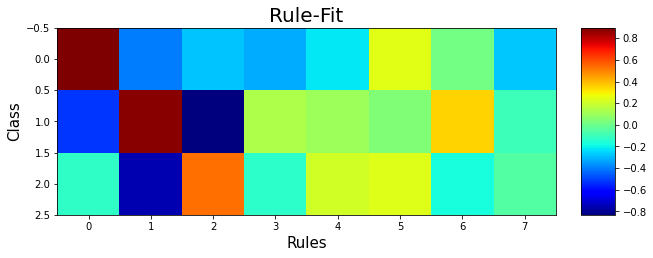

In [107]:
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable

rule_weights = model.rule_linear.weight.data.clone().cpu().detach().numpy()

fig, ax = plt.subplots(figsize=(10,8), facecolor="white")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='7%', pad="5%")
im = ax.imshow(rule_weights, cmap="jet" )
cb = fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel("Rules", fontsize=15)
ax.set_ylabel("Class", fontsize=15)
ax.set_title("Rule-Fit", fontsize=20)